In [ ]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [293]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import iexfinance.stocks as stocks
from tools import data, string
import style

<IPython.core.display.Javascript object>

### Scrape tickers from Wikipeida + get company information from IEX
You will need an account to get a token for IEX API

In [294]:
info = data.get_sp500_info()
info.head(3)

symbol          companyName                       exchange  \
MMM     MMM               3M Co.  NEW YORK STOCK EXCHANGE, INC.   
ABT     ABT  Abbott Laboratories  NEW YORK STOCK EXCHANGE, INC.   
ABBV   ABBV           Abbvie Inc  NEW YORK STOCK EXCHANGE, INC.   

                                          industry                  website  \
MMM          Offices of Bank Holding Companies ...  https://www.3mindia.in/   
ABT   Pharmaceutical Preparation Manufacturing ...   https://www.abbott.com   
ABBV  Pharmaceutical Preparation Manufacturing ...  https://www.abbvie.com/   

     description               CEO         securityName issueType  \
MMM                 George Buckley               3M Co.        cs   
ABT                    Robert Ford  Abbott Laboratories        cs   
ABBV              Richard Gonzalez           Abbvie Inc        cs   

                                       sector primarySicCode employees  \
MMM   Management of Companies and Enterprises           3841      None   
ABT                             Manufacturing           2834      None   
ABBV                            Manufacturing           2834      None   

                                                   tags             address  \
MMM   [Producer Manufacturing, Industrial Conglomera...           3M Center   
ABT   [Health Technology, Medical Specialties, Manuf...  100 Abbott Park Rd   
ABBV  [Health Technology, Pharmaceuticals: Major, Ma...     1 N Waukegan Rd   

               address2      state           city         zip country  \
MMM   Bldg. 220-13E-26A  Minnesota     Saint paul  55144-1000      US   
ABT                None   Illinois    Abbott park  60064-3500      US   
ABBV               None   Illinois  North chicago  60064-1802      US   

            phone  
MMM   16517331474  
ABT   12246676100  
ABBV  18479327900

<IPython.core.display.Javascript object>

### Get price data from Yahoo Finance

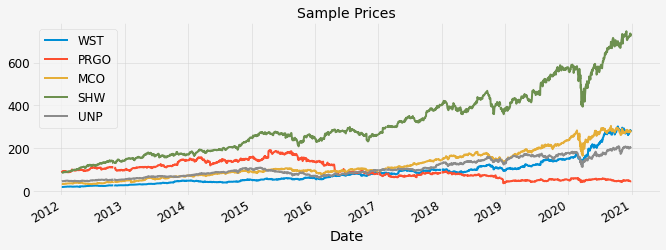

<IPython.core.display.Javascript object>

In [295]:
tickers = info["symbol"].tolist()
start = "2012-01-01"
end = "2020-12-29"
prices = data.get_prices(tickers, start, end)
prices.sample(5, axis=1).plot()
plt.title("Sample Prices")
plt.show()

### Scrape H1B filings from h1bdata.info

In [296]:
functions = ["ANALYTICS", "DATA+SCI", "DATA+ANA", "STATIST", "MACHINE+LEARNING"]
levels = ["JUNIOR", "SENIOR", "LEAD", "STAFF", "MANAGER", "CHIEF", "PRINCIPAL"]
combos = ["+".join([l, f]) for l in levels for f in functions]
search_terms = functions + combos

filings = data.get_h1b(search_terms)
filings.sample(3)

EMPLOYER                    JOB TITLE BASE SALARY  \
215     SVB FINANCIAL GROUP  ANALYTICS VALUATION MANAGER       85134   
1427         ANCHORFREE INC                 DATA ANALYST      100000   
1442  UBER TECHNOLOGIES INC                 DATA ANALYST      100506   

               LOCATION SUBMIT DATE  START DATE CASE STATUS  
215   SAN FRANCISCO, CA  08/26/2016  09/10/2016   CERTIFIED  
1427     MENLO PARK, CA  03/16/2016  09/12/2016   CERTIFIED  
1442  SAN FRANCISCO, CA  01/23/2019  01/25/2019   CERTIFIED

<IPython.core.display.Javascript object>

### Match company names

In [297]:
from tools.string import standardize_name, StringComparer

iex_names = info["companyName"].apply(standardize_name).tolist()
h1b_names = filings["EMPLOYER"].apply(standardize_name).tolist()
sc = StringComparer(h1b_names, iex_names)
matches = sc.get_matches(threshold=0.75)

h1b_raw = filings["EMPLOYER"].drop_duplicates()
h1b_raw2clean = dict(zip(h1b_raw, h1b_raw.apply(standardize_name)))
iex_raw = info["companyName"].drop_duplicates()
iex_clean2raw = dict(zip(iex_raw.apply(standardize_name), iex_raw))
h1b2iex = matches.set_index("s")["t"].to_dict()
iex2ticker = info.set_index("companyName")["symbol"].to_dict()

filings["TICKER"] = (
    filings["EMPLOYER"]
    .map(h1b_raw2clean)
    .map(h1b2iex)
    .map(iex_clean2raw)
    .map(iex2ticker)
)

String matching complete - 2.70s


<IPython.core.display.Javascript object>

### Clean and explore H1B data
Keep only companies with at least 10 filings

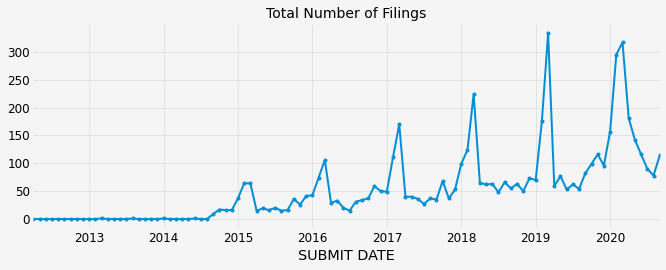

<IPython.core.display.Javascript object>

In [298]:
filings = filings.dropna()
filings["BASE SALARY"] = filings["BASE SALARY"].apply(int)
filings["SUBMIT DATE"] = pd.to_datetime(filings["SUBMIT DATE"])
f = filings.pivot_table(
    columns="EMPLOYER", index="SUBMIT DATE", values="BASE SALARY", aggfunc="count"
)
f = f.loc[:, f.columns[f.sum() >= 10]]
f = f.fillna(0)
plt.title("Total Number of Filings")
f.resample("M").sum().sum(1).plot(marker=".")
f.index.name = None
f.index = f.index - pd.offsets.MonthBegin(4)
f.index = f.index.year
f = f.groupby(f.index).sum()
f = f.iloc[1:-1]
plt.show()

The spike in applications in Q1 is due to the April 1st deadline. We see that the number of H-1B data analysis jobs have been growing consistently in recent years, which 2020 being an exception. COVID-19 might have played a role in this.

#### Aggregate by year
Since new H-1Bs are only processed in April each year, it might be more useful to look at total number of applications from Apr 1 to March 31 of the following year for each company. We should also ignore post-2020 April since it's not complete

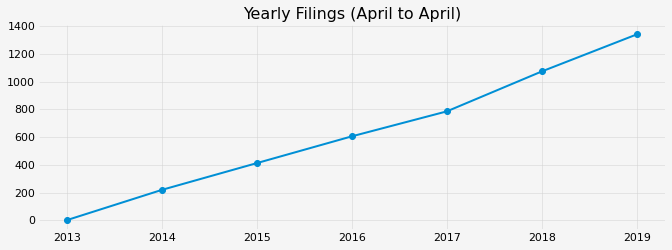

<IPython.core.display.Javascript object>

In [40]:
f.sum(1).plot(marker="o")
plt.title("Yearly Filings (April to April)")
plt.show()

#### Heatmap plot

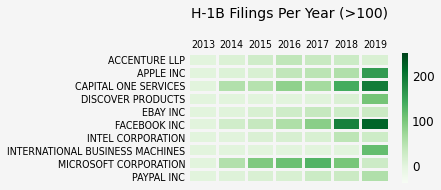

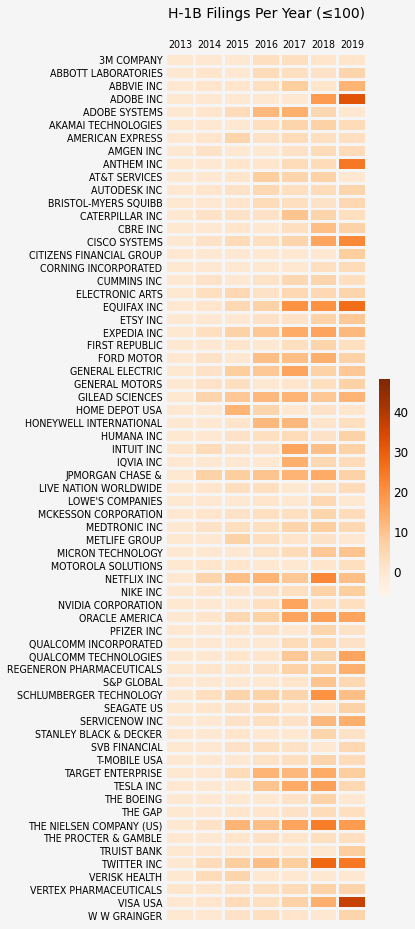

<IPython.core.display.Javascript object>

In [300]:
X1 = f.loc[:, (f.sum() > 100).tolist()]
X1.columns = [" ".join(c.split()[: max(2, len(c.split()) - 1)]) for c in X1.columns]
plt.figure(figsize=(4, X1.shape[1] / 4.5))
plt.tick_params(axis="both", labeltop=True, labelbottom=False, labelsize=9.5)
style_params = dict(linewidths=2, linecolor="#f5f5f5", cbar=True)
sns.heatmap(X1.T, cmap="Greens", vmin=-40, vmax=250, **style_params)
plt.title("H-1B Filings Per Year (>100)\n")
plt.show()

X2 = f.loc[:, (f.sum() <= 100).tolist()]
X2.columns = [" ".join(c.split()[: max(2, len(c.split()) - 1)]) for c in X2.columns]
plt.figure(figsize=(4, X2.shape[1] / 4.5))
plt.tick_params(axis="both", labeltop=True, labelbottom=False, labelsize=9.5)
cbar_kws = dict(shrink=0.25)
style_params = dict(linewidths=2, linecolor="#f5f5f5", cbar=True, cbar_kws=cbar_kws)
sns.heatmap(X2.T, cmap="Oranges", vmin=-6, vmax=48, **style_params)
plt.title("H-1B Filings Per Year (â‰¤100)\n")
plt.show()

#### Largest n filers

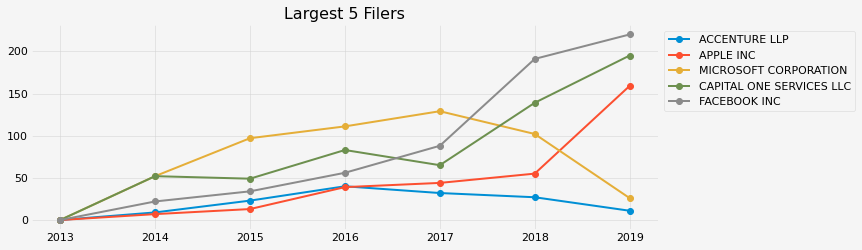

<IPython.core.display.Javascript object>

In [50]:
n = 5
largest = f.sum().sort_values().index[-n:]
f[largest].plot(marker="o")
plt.title(f"Largest {n} Filers")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Biggest losers(gainers) from peak (trough)

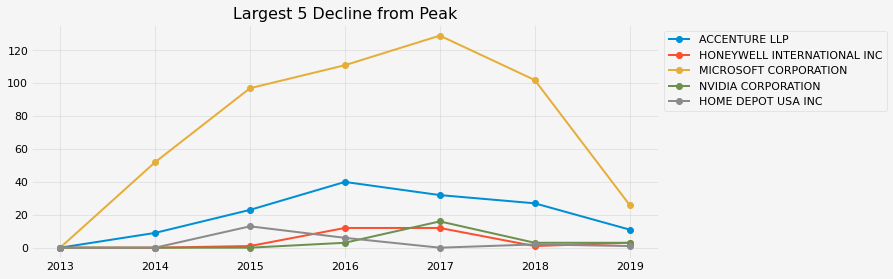

<IPython.core.display.Javascript object>

In [51]:
n = 5
dips = f.apply(lambda x: (x.max() - x.iloc[-1]) / x.max() if x.iloc[-1] > 0 else 0)
biggest_dip = dips.sort_values().index[-n:]
colors = ["r", "b", "g", "orange", "teal"]
f[biggest_dip].plot(marker="o", figsize=(10, 4))
plt.legend(bbox_to_anchor=(1, 0, 1, 1), loc="upper left")
plt.title("Largest 5 Decline from Peak")
plt.show()

### Clustering
To categorize hiring trend into broad categories, we can run clustering algorithms on the time series data. To add additional information, we can perform regression on each time series and use the coefficients as additional features.

In [684]:
from sklearn.linear_model import Lasso

betas = []
alpha = []
degree = 3
for col in f_norm:
    y = f_norm[col].values
    x = np.arange(len(y))
    variables = np.vstack([x ** d for d in range(1, degree)])
    reg = Lasso(fit_intercept=False)
    reg.fit(variables.T[3:], y[3:])
    betas.append(reg.coef_)
    alpha.append(reg.intercept_)
Z = np.vstack([np.array(alpha), np.array(betas).T])

<IPython.core.display.Javascript object>

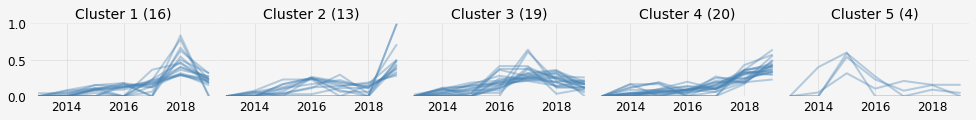

<IPython.core.display.Javascript object>

In [718]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

k = 5
X = np.vstack((f_norm.values, Z))
X = StandardScaler().fit_transform(X)
clusterer = KMeans(n_clusters=k, random_state=42)
cluster = clusterer.fit_predict(X.T)

fig, axes = plt.subplots(1, k, figsize=(k * 3, 1.25))
fig.subplots_adjust(wspace=0)
for i, ax in zip(range(k), axes.ravel()):
    data = f_norm.iloc[:, np.where(cluster == i)[0]]
    ax.plot(data, alpha=-0.3 + 1 / len(data) ** 0.2, c="steelblue")
    ax.set_ylim(0, 1)
    ax.set_title(f"Cluster {i+1} ({data.shape[1]})")
    ax.set_yticklabels([]) if i else 0
plt.show()

#### Cluster Interpretation:
* Cluster 1 - spike in 2018 then dip in 2019
* Cluster 2 - spike in 2019
* Cluster 3 - spike in 2016-2018 then gradual decrease
* Cluster 4 - smooth gradual increase
* Cluster 5 - early spikes then decrease and stagnant